In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import mathieu_a, mathieu_b
from scipy.optimize import minimize, differential_evolution
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# Units
amu = 1.6605e-27
ec = 1.60217662e-19

## Setup Constants
RF = 300e3
Omega = 2*np.pi*RF
r0 = 0.0092
z0 = 0.0088

charge = 1*ec

N = 2000
dRF = 1
dDC = 1
m=500*amu

In [12]:
plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=18)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=16, top=True, direction="in")  # skriftstørrelse af ticks og viser ticks øverst
plt.rc("ytick", labelsize=16, right=True, direction="in")
plt.rc("axes", titlesize=18)
plt.rc("legend", fontsize=16)

In [2]:
def q_to_V_conv(m):
    return m*Omega**2*(r0**2 + 2*z0**2)/(8*charge)
def a_to_V_conv(m):
    return -m*Omega**2*(r0**2 + 2*z0**2)/(16*charge)
def V_to_q_conv(m):
    return 8*charge/(m*Omega**2*(r0**2 + 2*z0**2))
def V_to_a_conv(m):
    return -16*charge/(m*Omega**2*(r0**2 + 2*z0**2))

In [3]:
def is_allowed_lower(m, dm, dRF, dDC, q_probe=0.781, a_lower=0.08):
    #check within allowed region
    q = dRF*V_to_q_conv(m)+q_probe
    a = dDC*V_to_a_conv(m)+a_lower
    if q < 0.780906:
        if not (a < -2*mathieu_a(0, q/2) and a > mathieu_a(0, q)): # Check if unstable in r or z
            return False
    else:
        if not (a < mathieu_b(1, q) and a > mathieu_a(0, q)):
            return False

    # #Check if lower mass is rejected
    q = dRF*V_to_q_conv(m-dm)+q_probe*m/(m-dm)
    a = dDC*V_to_a_conv(m-dm)+a_lower*m/(m-dm)
    if q < 0.780906:
        if (a < -2*mathieu_a(0, q/2) and a > mathieu_a(0, q)): # Check if unstable in r or z
            return False
    else:
        if  (a < mathieu_b(1, q) and a > mathieu_a(0, q)):
            return False

    return True
def is_allowed_upper(m, dm, dRF, dDC, q_probe=0.781, a_upper=-0.27):
    #check within allowed region
    q = dRF*V_to_q_conv(m)+q_probe
    a = dDC*V_to_a_conv(m)+a_upper
    if q < 0.780906:
        if not (a < -2*mathieu_a(0, q/2) and a > mathieu_a(0, q)): # Check if unstable in r or z
            return False
    else:
        if not (a < mathieu_b(1, q) and a > mathieu_a(0, q)):
            return False

    #Check if upper mass is rejected
    q = dRF*V_to_q_conv(m+dm)+q_probe*m/(m+dm)
    a = dDC*V_to_a_conv(m+dm)+a_upper*m/(m+dm)
    if q < 0.780906:
        if (a < -2*mathieu_a(0, q/2) and a > mathieu_a(0, q)): # Check if unstable in r or z
            return False
    else:
        if  (a < mathieu_b(1, q) and a > mathieu_a(0, q)):
            return False

    return True
def optimize_probing_points_at_res(dm):
    def optimize_probing_points(args):
        q_probe, a_lower, a_upper = args
        rand_dRF = np.random.normal(0, dRF, N)
        rand_dDC = np.random.normal(0, dDC, N)
        points = np.stack((rand_dRF, rand_dDC), axis=1)
        allowed = [False]*N

        for i in range(N):
            allowed[i] = is_allowed_lower(m, dm, *points[i], q_probe, a_lower) and is_allowed_upper(m, dm, *points[i], q_probe, a_upper)
        # print(sum(allowed))
        return -sum(allowed)
    return optimize_probing_points
    
def allowed_at_res(_dm):
    q_probe, a_lower, a_upper = 0.8191838386272174, 0.054909814382723604, -0.30093933743623136
    rand_dRF = np.random.normal(0, dRF, N)
    rand_dDC = np.random.normal(0, dDC, N)
    points = np.stack((rand_dRF, rand_dDC), axis=1)
    allowed = [False]*N
    for i in range(N):
        allowed[i] = is_allowed_lower(m, _dm, *points[i], q_probe, a_lower) and is_allowed_upper(m, _dm, *points[i], q_probe, a_upper)

    return sum(allowed)

In [5]:
res = differential_evolution(optimize_probing_points_at_res(50*amu), ([0.5, 0.83], [0, 0.15], [-0.4, 0.2]))
res
#0.81727746,  0.07186452, -0.30027223

     fun: -9997.0
 message: 'Optimization terminated successfully.'
    nfev: 991
     nit: 18
 success: True
       x: array([ 0.81727746,  0.07186452, -0.30027223])

In [29]:
q_probe, a_lower, a_upper = res.x
print(q_probe, a_lower, a_upper)
#0.8191838386272174 0.054909814382723604 -0.30093933743623136 for m=500 dm=50
#q_probe, a_lower, a_upper = 0.8191838386272174, 0.054909814382723604, -0.30093933743623136
optimize_probing_points_at_res(50*amu)(res.x)

NameError: name 'res' is not defined

In [10]:
dms = np.linspace(20*amu, 60*amu, 100)
allowed_dms = np.array([allowed_at_res(dm) for dm in dms])

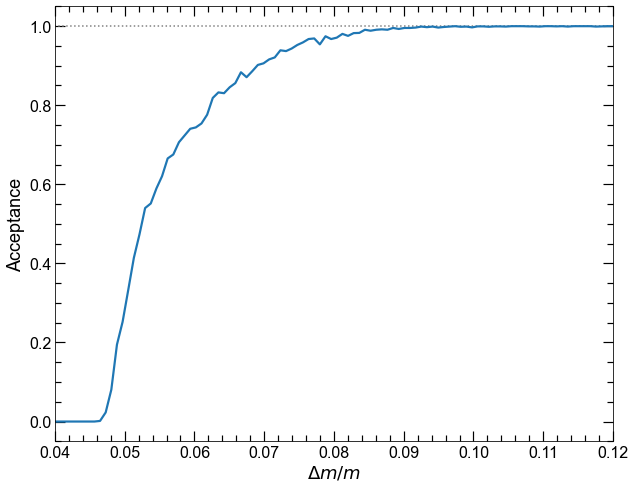

In [44]:
fig, ax = plt.subplots(1, 1)
ax.plot(dms/m, allowed_dms/N, lw=2.2)
ax.hlines(1, 0, 0.2, ls=':', colors='grey')
ax.set_xlabel("$\Delta m/m$")
ax.set_ylabel("Acceptance")
ax.set_xlim(0.04, 0.12)
fig.set_size_inches(10, 8)

plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(MultipleLocator(0.002))
ax.xaxis.set_major_locator(MultipleLocator(0.01))

In [40]:
qs = [np.linspace(0, 1.23978, 100), np.linspace(0.780906, 1.351218, 100), np.linspace(0, 0.780906, 100), np.linspace(1.23978, 1.351218, 100)]
mathieuCurves = [mathieu_a(0, qs[0]), mathieu_b(1, qs[1]), mathieu_a(0, qs[2]/2), mathieu_b(1, qs[3]/2)]

In [42]:
dm = 50*amu
q_probe, a_lower, a_upper = 0.8191838386272174, 0.054909814382723604, -0.30093933743623136
rand_dRF = np.random.normal(0, dRF, N)
rand_dDC = np.random.normal(0, dDC, N)

points = np.stack((rand_dRF, rand_dDC), axis=1)
allowed = [False]*N
for i in range(N):
    allowed[i] = is_allowed_lower(m, dm, *points[i], q_probe, a_lower) and is_allowed_upper(m, dm, *points[i], q_probe, a_upper)

(200.0, -50.0)

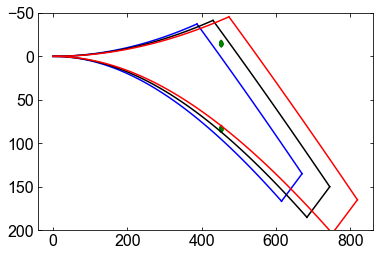

In [43]:
for i in range(N):
    plt.plot(points[i][0]+q_probe*q_to_V_conv(m), points[i][1]+a_upper*a_to_V_conv(m), 'o', ms=0.4, color = 'g' if allowed[i] else 'r')
    plt.plot(points[i][0]+q_probe*q_to_V_conv(m), points[i][1]+a_lower*a_to_V_conv(m), 'o', ms=0.4, color = 'g' if allowed[i] else 'r')
for mp, c in zip((m-dm, m, m+dm), ('b', 'k', 'r')):
    # Z stable solutions between
    plt.plot(qs[0]*q_to_V_conv(mp), mathieuCurves[0]*a_to_V_conv(mp), c=c, lw=1.5)
    plt.plot(qs[1]*q_to_V_conv(mp), mathieuCurves[1]*a_to_V_conv(mp), c=c, lw=1.5)

    # R stable solutions between
    plt.plot(qs[2]*q_to_V_conv(mp), -mathieuCurves[2]*a_to_V_conv(mp)*2, c=c, lw=1.5)
    plt.plot(qs[3]*q_to_V_conv(mp), -mathieuCurves[3]*a_to_V_conv(mp)*2, c=c, lw=1.5)

plt.ylim(200, -50)

In [357]:
optimize_probing_points(res.x)

-973